In [ ]:
"""
Este programa muestra la primera prueba hecha de una GAN 3D
se tomo el codigo expuesto en el libro de Jason Brownlee; Generative Adversarial
Networks with python

"""

#Import from library
from datetime import date, time, datetime
#Importar librerias
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dropout
from keras.layers import LeakyReLU
#from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
# example of loading the mnist dataset
from keras.datasets.cifar10 import load_data
# load saved models
from keras.models import load_model

170498071/170498071 [==============================] - 16s 0us/step
Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


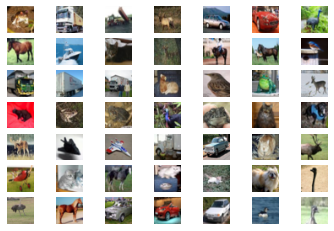

In [ ]:

# Abrir archivo de texto para guardar resultados
#datos= open("datos2D.txt",'wt')
#load the images into memory
(trainX,trainy), (testX,testy) =load_data()
# plot images from the training dataset
for i in range(49):
    # define subplot
    plt.subplot(7, 7, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(trainX[i])
filename = 'base_plot_3DGAN{}.png'.format(str(date.today()))
plt.savefig(filename)
#plt.close()
#plt.imshow()
#summarize the shape of the dataset
print('Train',trainX.shape, trainy.shape)
print('Test',testX.shape, testy.shape)


In [ ]:

# define the standalone dicriminator model
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
       #normal
    model.add(Conv2D(64,
                      (3,3),
                      strides=(2,2),
                      padding='same',
                      input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

      #downsample
    model.add(Conv2D(128,
                      (3,3),
                      strides=(2,2),
                      padding='same'))
    model.add(LeakyReLU(alpha=0.2))
      
      #downsample
    model.add(Conv2D(128,
                      (3,3),
                      strides=(2,2),
                      padding='same'))
    model.add(LeakyReLU(alpha=0.2))

      #downsample
    model.add(Conv2D(256,
                      (3,3),
                      strides=(2,2),
                      padding='same'))
    model.add(LeakyReLU(alpha=0.2))      

      #classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,
                    activation='sigmoid'))
    model.summary()
    #compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:

#define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes =256 *4*4 #features maps*dimensions
    model.add(Dense(n_nodes,
                    input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128,
                              (4,4),
                              strides=(2,2),
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128,
                              (4,4),
                              strides=(2,2),
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128,
                              (4,4),
                              strides=(2,2),
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3,
                      (3,3),
                      activation='tanh',
                      padding='same'))
    return model


In [ ]:
#define the combined generator and dicriminatro model,
#for updating the generator
def define_gan(g_model,d_model):
    #make weights in the discriminator not trainable
    d_model.trainable = False
    #connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    #add the discriminator
    model.add(d_model)
    #compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  )#metrics=['accuracy'])
    return model


In [ ]:

## load and prepare cifar10 training images
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X-127.5) / 127.5
    return X


In [ ]:

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate ✬real✬ class labels (1)
    y = ones((n_samples, 1))
    return X, y


In [ ]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


In [ ]:

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create ✬fake✬ class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [ ]:
# create and save a plot of generated images 
def save_plot(examples, epoch, n=7):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n,n, 1+i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
        # save plot to file
    filename = 'generated_3DGAN_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [ ]:

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    #save data
    #datos.write('Epoch%03d  >Accuracy real: %.0f%%, fake: %.0f%%' % (epoch+1, acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_3D_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)



In [ ]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim,
          n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs

    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected ✬real✬ samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
           # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate ✬fake✬ examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator✬s error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
            # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [ ]:

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         2

4/4 [==============================] - 0s 6ms/step
>11, 1/195, d1=0.589, d2=0.620 g=0.903
4/4 [==============================] - 0s 5ms/step
>11, 2/195, d1=0.613, d2=0.638 g=0.869
4/4 [==============================] - 0s 5ms/step
>11, 3/195, d1=0.609, d2=0.666 g=0.851
4/4 [==============================] - 0s 5ms/step
>11, 4/195, d1=0.584, d2=0.667 g=0.847
4/4 [==============================] - 0s 4ms/step
>11, 5/195, d1=0.533, d2=0.696 g=0.866
4/4 [==============================] - 0s 3ms/step
>11, 6/195, d1=0.571, d2=0.653 g=0.878
4/4 [==============================] - 0s 4ms/step
>11, 7/195, d1=0.582, d2=0.680 g=0.895
4/4 [==============================] - 0s 4ms/step
>11, 8/195, d1=0.647, d2=0.670 g=0.870
4/4 [==============================] - 0s 4ms/step
>11, 9/195, d1=0.636, d2=0.687 g=0.876
4/4 [==============================] - 0s 4ms/step
>11, 10/195, d1=0.647, d2=0.671 g=0.868
4/4 [==============================] - 0s 4ms/step
>11, 11/195, d1=0.596, d2=0.674 g=0.882
4/4 [===

4/4 [==============================] - 0s 4ms/step
>21, 1/195, d1=0.559, d2=0.755 g=0.882
4/4 [==============================] - 0s 4ms/step
>21, 2/195, d1=0.623, d2=0.706 g=0.904
4/4 [==============================] - 0s 5ms/step
>21, 3/195, d1=0.671, d2=0.658 g=0.912
4/4 [==============================] - 0s 4ms/step
>21, 4/195, d1=0.686, d2=0.599 g=0.960
4/4 [==============================] - 0s 4ms/step
>21, 5/195, d1=0.712, d2=0.574 g=0.986
4/4 [==============================] - 0s 4ms/step
>21, 6/195, d1=0.683, d2=0.625 g=0.975
4/4 [==============================] - 0s 4ms/step
>21, 7/195, d1=0.698, d2=0.640 g=0.896
4/4 [==============================] - 0s 4ms/step
>21, 8/195, d1=0.692, d2=0.702 g=0.861
4/4 [==============================] - 0s 4ms/step
>21, 9/195, d1=0.785, d2=0.727 g=0.882
4/4 [==============================] - 0s 4ms/step
>21, 10/195, d1=0.765, d2=0.649 g=0.900
4/4 [==============================] - 0s 5ms/step
>21, 11/195, d1=0.776, d2=0.620 g=0.940
4/4 [===

4/4 [==============================] - 0s 5ms/step
>31, 1/195, d1=0.664, d2=0.638 g=0.829
4/4 [==============================] - 0s 4ms/step
>31, 2/195, d1=0.663, d2=0.658 g=0.840
4/4 [==============================] - 0s 4ms/step
>31, 3/195, d1=0.698, d2=0.663 g=0.858
4/4 [==============================] - 0s 6ms/step
>31, 4/195, d1=0.681, d2=0.612 g=0.863
4/4 [==============================] - 0s 4ms/step
>31, 5/195, d1=0.720, d2=0.617 g=0.852
4/4 [==============================] - 0s 5ms/step
>31, 6/195, d1=0.711, d2=0.627 g=0.849
4/4 [==============================] - 0s 6ms/step
>31, 7/195, d1=0.667, d2=0.687 g=0.831
4/4 [==============================] - 0s 4ms/step
>31, 8/195, d1=0.704, d2=0.627 g=0.848
4/4 [==============================] - 0s 6ms/step
>31, 9/195, d1=0.727, d2=0.636 g=0.842
4/4 [==============================] - 0s 6ms/step
>31, 10/195, d1=0.733, d2=0.628 g=0.857
4/4 [==============================] - 0s 5ms/step
>31, 11/195, d1=0.726, d2=0.650 g=0.842
4/4 [===

4/4 [==============================] - 0s 5ms/step
>41, 1/195, d1=0.701, d2=0.669 g=0.756
4/4 [==============================] - 0s 5ms/step
>41, 2/195, d1=0.701, d2=0.688 g=0.745
4/4 [==============================] - 0s 5ms/step
>41, 3/195, d1=0.672, d2=0.702 g=0.731
4/4 [==============================] - 0s 8ms/step
>41, 4/195, d1=0.686, d2=0.708 g=0.730
4/4 [==============================] - 0s 5ms/step
>41, 5/195, d1=0.667, d2=0.691 g=0.727
4/4 [==============================] - 0s 4ms/step
>41, 6/195, d1=0.676, d2=0.726 g=0.719
4/4 [==============================] - 0s 6ms/step
>41, 7/195, d1=0.660, d2=0.715 g=0.744
4/4 [==============================] - 0s 4ms/step
>41, 8/195, d1=0.681, d2=0.662 g=0.755
4/4 [==============================] - 0s 6ms/step
>41, 9/195, d1=0.656, d2=0.663 g=0.764
4/4 [==============================] - 0s 4ms/step
>41, 10/195, d1=0.633, d2=0.672 g=0.775
4/4 [==============================] - 0s 6ms/step
>41, 11/195, d1=0.624, d2=0.707 g=0.771
4/4 [===

4/4 [==============================] - 0s 4ms/step
>51, 1/195, d1=0.642, d2=0.711 g=0.731
4/4 [==============================] - 0s 5ms/step
>51, 2/195, d1=0.626, d2=0.701 g=0.739
4/4 [==============================] - 0s 4ms/step
>51, 3/195, d1=0.620, d2=0.765 g=0.731
4/4 [==============================] - 0s 6ms/step
>51, 4/195, d1=0.651, d2=0.751 g=0.747
4/4 [==============================] - 0s 4ms/step
>51, 5/195, d1=0.679, d2=0.677 g=0.776
4/4 [==============================] - 0s 4ms/step
>51, 6/195, d1=0.696, d2=0.624 g=0.779
4/4 [==============================] - 0s 5ms/step
>51, 7/195, d1=0.712, d2=0.635 g=0.781
4/4 [==============================] - 0s 4ms/step
>51, 8/195, d1=0.708, d2=0.654 g=0.771
4/4 [==============================] - 0s 5ms/step
>51, 9/195, d1=0.715, d2=0.669 g=0.752
4/4 [==============================] - 0s 5ms/step
>51, 10/195, d1=0.708, d2=0.694 g=0.758
4/4 [==============================] - 0s 4ms/step
>51, 11/195, d1=0.720, d2=0.668 g=0.759
4/4 [===

4/4 [==============================] - 0s 5ms/step
>61, 1/195, d1=0.630, d2=0.746 g=0.739
4/4 [==============================] - 0s 6ms/step
>61, 2/195, d1=0.583, d2=0.784 g=0.739
4/4 [==============================] - 0s 5ms/step
>61, 3/195, d1=0.616, d2=0.758 g=0.750
4/4 [==============================] - 0s 5ms/step
>61, 4/195, d1=0.687, d2=0.703 g=0.765
4/4 [==============================] - 0s 4ms/step
>61, 5/195, d1=0.675, d2=0.686 g=0.770
4/4 [==============================] - 0s 4ms/step
>61, 6/195, d1=0.678, d2=0.654 g=0.790
4/4 [==============================] - 0s 3ms/step
>61, 7/195, d1=0.702, d2=0.718 g=0.798
4/4 [==============================] - 0s 5ms/step
>61, 8/195, d1=0.699, d2=0.658 g=0.793
4/4 [==============================] - 0s 4ms/step
>61, 9/195, d1=0.714, d2=0.644 g=0.805
4/4 [==============================] - 0s 5ms/step
>61, 10/195, d1=0.727, d2=0.638 g=0.797
4/4 [==============================] - 0s 7ms/step
>61, 11/195, d1=0.730, d2=0.634 g=0.798
4/4 [===

4/4 [==============================] - 0s 6ms/step
>71, 1/195, d1=0.672, d2=0.720 g=0.734
4/4 [==============================] - 0s 4ms/step
>71, 2/195, d1=0.673, d2=0.703 g=0.721
4/4 [==============================] - 0s 7ms/step
>71, 3/195, d1=0.700, d2=0.690 g=0.714
4/4 [==============================] - 0s 5ms/step
>71, 4/195, d1=0.686, d2=0.709 g=0.738
4/4 [==============================] - 0s 6ms/step
>71, 5/195, d1=0.679, d2=0.663 g=0.743
4/4 [==============================] - 0s 5ms/step
>71, 6/195, d1=0.684, d2=0.671 g=0.748
4/4 [==============================] - 0s 5ms/step
>71, 7/195, d1=0.662, d2=0.670 g=0.744
4/4 [==============================] - 0s 4ms/step
>71, 8/195, d1=0.684, d2=0.665 g=0.740
4/4 [==============================] - 0s 4ms/step
>71, 9/195, d1=0.688, d2=0.686 g=0.747
4/4 [==============================] - 0s 4ms/step
>71, 10/195, d1=0.693, d2=0.694 g=0.743
4/4 [==============================] - 0s 5ms/step
>71, 11/195, d1=0.677, d2=0.669 g=0.728
4/4 [===

4/4 [==============================] - 0s 7ms/step
>81, 1/195, d1=0.712, d2=0.684 g=0.763
4/4 [==============================] - 0s 4ms/step
>81, 2/195, d1=0.709, d2=0.672 g=0.752
4/4 [==============================] - 0s 6ms/step
>81, 3/195, d1=0.713, d2=0.669 g=0.755
4/4 [==============================] - 0s 4ms/step
>81, 4/195, d1=0.728, d2=0.653 g=0.755
4/4 [==============================] - 0s 4ms/step
>81, 5/195, d1=0.694, d2=0.661 g=0.744
4/4 [==============================] - 0s 4ms/step
>81, 6/195, d1=0.690, d2=0.682 g=0.730
4/4 [==============================] - 0s 4ms/step
>81, 7/195, d1=0.693, d2=0.690 g=0.719
4/4 [==============================] - 0s 7ms/step
>81, 8/195, d1=0.679, d2=0.705 g=0.730
4/4 [==============================] - 0s 4ms/step
>81, 9/195, d1=0.684, d2=0.678 g=0.710
4/4 [==============================] - 0s 4ms/step
>81, 10/195, d1=0.689, d2=0.720 g=0.734
4/4 [==============================] - 0s 5ms/step
>81, 11/195, d1=0.674, d2=0.681 g=0.737
4/4 [===

4/4 [==============================] - 0s 7ms/step
>91, 1/195, d1=0.677, d2=0.716 g=0.741
4/4 [==============================] - 0s 5ms/step
>91, 2/195, d1=0.686, d2=0.707 g=0.760
4/4 [==============================] - 0s 7ms/step
>91, 3/195, d1=0.675, d2=0.670 g=0.772
4/4 [==============================] - 0s 4ms/step
>91, 4/195, d1=0.685, d2=0.638 g=0.770
4/4 [==============================] - 0s 6ms/step
>91, 5/195, d1=0.722, d2=0.672 g=0.755
4/4 [==============================] - 0s 5ms/step
>91, 6/195, d1=0.730, d2=0.652 g=0.747
4/4 [==============================] - 0s 5ms/step
>91, 7/195, d1=0.728, d2=0.665 g=0.757
4/4 [==============================] - 0s 5ms/step
>91, 8/195, d1=0.702, d2=0.668 g=0.757
4/4 [==============================] - 0s 5ms/step
>91, 9/195, d1=0.720, d2=0.662 g=0.755
4/4 [==============================] - 0s 4ms/step
>91, 10/195, d1=0.727, d2=0.668 g=0.774
4/4 [==============================] - 0s 5ms/step
>91, 11/195, d1=0.699, d2=0.634 g=0.773
4/4 [===